## Key words matrix takes forever to make, so just download the csv from drive and load it in instead of going through the code.

In [2]:
!pip install lightfm

In [2]:
import pandas as pd
import numpy as np
import gzip
import json
import re
import matplotlib.pyplot as plt
from rake_nltk import Rake

# Use Rake to parse metadata for keywords

In [33]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('meta_Luxury_Beauty.json.gz')

## Cleaning

In [5]:
#remove NaN from description
df.loc[df['description'].isna(),'description']=""

In [6]:
#remove NaN from title
df.loc[df['title'].isna(),'title']=""

In [7]:
#remove NaN from price
df.loc[df['price'].isna(),'price']=""

In [8]:
#create description string
for idx,i in enumerate(df['description']): 
    df.loc[idx,'description'] = ' '.join([str(elem) for elem in i])+df.loc[idx,'title']


In [9]:
df['key_desc'] = ""
#use rake to get keywords from game description+title
for index, row in df.iterrows():
    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()
    summary = str(row['description'])
    # extracting the words by passing the text
    r.extract_keywords_from_text(summary)

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()
    a=list(key_words_dict_scores.keys())
    # assigning the key words to the new column for the corresponding movie
    df.at[index,'key_desc']= a

In [10]:
#create description string
for idx,i in enumerate(df['key_desc']): 
    df.loc[idx,'key_desc'] = ' '.join([str(elem) for elem in i])

In [11]:
df=df[['asin','key_desc']]

# Fit a LightFM Model

## Create Dataset for Model

In [12]:


#get reviews
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [13]:
df2 = getDF('Luxury_Beauty_5.json.gz')

In [14]:
#append key words field to main datset
df2=df2.merge(df,on='asin')

In [15]:
#create vectorized matrix from the bag of words
df3=df2[['asin','key_desc']].drop_duplicates()
df3=df3.set_index('asin')
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
item_features = count.fit_transform(df3['key_desc'])
indices = pd.Series(df3.index)

In [16]:
#comupte pairwise similarity between items
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(item_features, item_features)


In [17]:
#Flag 10 most similar items for each item
x=np.zeros((1577,1577))
for i in range(0,1577):
    score_series = pd.Series(cosine_sim[i]).sort_values(ascending = False)
    top_10_indexes = list(score_series.iloc[1:11].index)
    for j in top_10_indexes:
        x[i,j]=1


In [18]:
#use neighborhoods matrix to create 100 clusters to pass into model as item features
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 100).fit(x)
clusters = model.labels_
clus=pd.DataFrame(clusters,columns=['Cluster'])
clus['asin']=indices
df2=df2.merge(clus,on='asin')

In [19]:
#fit reviewer and game id to dataset
from lightfm.data import Dataset
dataset=Dataset()
dataset.fit(df2.reviewerID.values,df2.asin.values)
dataset.fit_partial(items=clus.asin.values,item_features=clus.Cluster.values)

C:\Users\cnaka\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [20]:
#create tuple of user and item for interactions fitting
user_sub = df2[['reviewerID', 'asin']]
user_tuples = [tuple(x) for x in user_sub.values]
item_sub = clus[['asin','Cluster']]
item_tuples = []
for i in range(0,len(clus['asin'])):
    item_tuples.append((clus.loc[i,'asin'],[clus.loc[i,'Cluster']]))

In [21]:
#create interactions matrix
(interactions,weights) = dataset.build_interactions(user_tuples)
item_features = dataset.build_item_features(item_tuples)

In [22]:
#remove duplicates
from scipy.sparse import csr_matrix,coo_matrix
interactions = csr_matrix(interactions)
interactions = coo_matrix(interactions)

In [23]:
item_features

<1577x1677 sparse matrix of type '<class 'numpy.float32'>'
	with 3154 stored elements in Compressed Sparse Row format>

## Fit Collaborative Only Model

In [24]:
#create training split
from lightfm.cross_validation import random_train_test_split
train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(seed=300))

In [46]:
#model creation
from lightfm import LightFM
# Define a new model instance
model = LightFM(loss='warp',
                no_components=40)

# Fit the hybrid model, remember to pass in item features.
model = model.fit(train,
                #item_features=item_features,
                epochs=20,
                num_threads=4)

In [26]:
#evaluate training AUC
from lightfm.evaluation import auc_score
# Don't forget the pass in the item features again!
train_auc = auc_score(model,
                      train,
                      #item_features=item_features
                     ).mean()
print('Collaborative training set AUC: %s' % train_auc)
#evaluate test set AUC
test_auc = auc_score(model,
                    test,
                    train_interactions=train,
                    #item_features=item_features
                    ).mean()
print('Collaborative test set AUC: %s' % test_auc)
#Training Precision@K
from lightfm.evaluation import precision_at_k

train_precision = precision_at_k(model, train, #item_features=item_features, 
                                 k=5).mean()

print("Train Precision @ K: {}".format(train_precision))
#Test Precision@K

test_precision = precision_at_k(model, test, #item_features=item_features,
                                k=5).mean()

print("Test Precision @ K: {}".format(test_precision))

Collaborative training set AUC: 0.9979415
Collaborative test set AUC: 0.83832663
Train Precision @ K: 0.6169643402099609
Test Precision @ K: 0.06284875422716141


## Fit Hybrid Model

In [42]:
#model creation
from lightfm import LightFM
# Define a new model instance
model = LightFM(loss='warp',no_components=40)

# Fit the hybrid model, remember to pass in item features.
model = model.fit(train,
                item_features=item_features,
                epochs=20,
                num_threads=6)

In [28]:
#evaluate training AUC
from lightfm.evaluation import auc_score
# Don't forget the pass in the item features again!
train_auc = auc_score(model,
                      train,
                      item_features=item_features
                     ).mean()
print('Hybrid training set AUC: %s' % train_auc)
#evaluate test set AUC
test_auc = auc_score(model,
                    test,
                    train_interactions=train,
                    item_features=item_features
                    ).mean()
print('Hybrid test set AUC: %s' % test_auc)
#Training Precision@K
from lightfm.evaluation import precision_at_k

train_precision = precision_at_k(model, train, item_features=item_features, 
                                 k=5).mean()

print("Train Precision @ K: {}".format(train_precision))
#Test Precision@K

test_precision = precision_at_k(model, test, item_features=item_features,
                                k=5).mean()

print("Test Precision @ K: {}".format(test_precision))

Hybrid training set AUC: 0.9895915
Hybrid test set AUC: 0.8662932
Train Precision @ K: 0.3596639037132263
Test Precision @ K: 0.07400881499052048


In [29]:
def cross_validate(test_percentage,k):
    test_precision = []
    for i in range(0,10): 
        train, test = random_train_test_split(interactions, test_percentage=test_percentage,random_state=np.random.RandomState(seed=i))
        # Define a new model instance
        model = LightFM(loss='warp',no_components=40)
        model = model.fit(train,
                item_features=item_features,
                epochs=20,
                num_threads=6)
        test_precision.append(precision_at_k(model, test, item_features=item_features,
                                k=5).mean()*100)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(test_precision,label='')
    ax.set_title('Test Sample Precision at K')
    ax.set_ylabel('Precision %')
    ax.set_xlabel('Fold')
    test_precision = []
    for i in range(0,10): 
        train, test = random_train_test_split(interactions, test_percentage=test_percentage,random_state=np.random.RandomState(seed=i))
        # Define a new model instance
        model = LightFM(loss='warp',no_components=40)
        model = model.fit(train,
                #item_features=item_features,
                epochs=20,
                num_threads=6)
        test_precision.append(precision_at_k(model, test, #item_features=item_features,
                                k=5).mean()*100)
    ax.plot(test_precision)
    ax.legend(['Hybrid Model','Collaborative Model'])

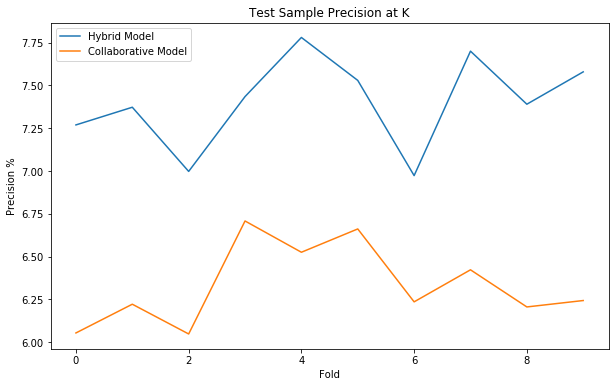

In [30]:
cross_validate(.2,10)

## Generate Recommendations

In [31]:
def rec(ids):
    pred = model.predict(user_ids=ids,item_ids=list(dataset.mapping()[2].values()))
    l=list(zip(list(dataset.mapping()[2].keys()),list(pred)))
    pred_df = pd.DataFrame(l,columns = ['asin','recommendation_scores'])
    pred_df = pred_df.sort_values("recommendation_scores",ascending=False)
    return pred_df

In [ ]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('meta_Luxury_Beauty.json.gz')

In [47]:
#Find Predictions for User
preds = rec(700)
preds = preds.merge(df[['asin','title']],on='asin').drop_duplicates().iloc[0:10,:]
preds[['title','recommendation_scores']]

,title,recommendation_scores
0,"L&#39;Occitane 20% Shea Butter Hand Cream, 5....",2.171483
1,L'Occitane 15% Shea Butter Foot Cream Enriched...,1.417230
2,"Mustela Baby Wipes, Unscented",1.068356
3,DERMASURI Rice Milk Brightening Face Exfoliato...,0.873441
4,Dermablend Smooth Liquid Foundation with SPF 2...,0.849193
5,"Mustela 1.2.3. Diaper Rash Cream, Baby Skin Pr...",0.844605
6,La Roche-Posay Thermal Spring Water for Sensit...,0.777537
8,L&#39;Occitane Cleansing &amp; Softening Almo...,0.759642
9,Meaningful Beauty Vitality Oil,0.672057
10,"Obagi Professional-C Serum, 1 fl. oz.",0.667480


In [50]:
#COmpare with Reviewed Items
pd.DataFrame(df2[df2['reviewerID']==list(dataset.mapping()[0].keys())[700]].merge(df[['asin','title']],on='asin')['title']).iloc[8:15,:]

,title
8,La Roche-Posay Serozinc Face Toner for Oily Sk...
9,"Hampton Sun SPF 15 Super Hydrating Face Cream,..."
10,L'Occitane Best of Collection
11,L'Occitane Luxurious Divine Star
12,"SKIN&amp;CO Roma Truffle Therapy Serum, 1.0 fl..."
13,Obliphica Professional Seaberry Moisture Cream...
14,"Mustela Baby Wipes, Unscented"


## Segmented Customer Analysis

In [3]:
# Import subsets based on previous analysis 
subsets = pd.read_csv("customer_segments.csv")
subsets=subsets.drop(columns=['cent'])
subsets=subsets.set_index('Unnamed: 0')
graysheep=subsets.index[subsets['group'] == 'gray_sheep'].tolist()
typical=subsets.index[subsets['group'] == 'typical_customer'].tolist()
cold_start=subsets.index[subsets['group'] == 'cold_start'].tolist()

In [ ]:
# Create test set for "Gray Sheep"

x=[dataset.mapping()[0][I] for I in graysheep]
x.sort()
len(x)

idx =[]
for i in test.row:
    idx.append(i in x)
shape = test.shape
uids, iids, data = (test.row,
                    test.col,
                    test.data)

graysheep_test=coo_matrix((data[idx],
                           (uids[idx],
                            iids[idx])),
                          shape=shape,
                          dtype=interactions.dtype)

In [ ]:
# Create test set for "Typical Customers"

x=[dataset.mapping()[0][I] for I in typical]
x.sort()
len(x)

idx =[]
for i in test.row:
    idx.append(i in x)
shape = test.shape
uids, iids, data = (test.row,
                    test.col,
                    test.data)

typicaluser_test=coo_matrix((data[idx],
                           (uids[idx],
                            iids[idx])),
                          shape=shape,
                          dtype=interactions.dtype)

Now can go through model fitting process above to run on test populations with only certain customer segments